## Introduction

This notebook investigates the idealized behavior and breakdown point of the
simple cash strategy in a trading account:

**Target margin usage is a linear function of the drawdown.**

The main idea behind this strategy is to codify "buy low, sell high" as
directly as possible, by borrowing money to buy stock in proportion to its
drawdown.

For our purposes we assume we hold a single share of a security with initial
price of 1. Assuming we trade continuously and can hold continuous fractions of
a share, we will investigate the following question:

**Following the strategy above, what does the shares vs. drawdown graph look like?**

*CAVEAT: actual differential (i.e. price-reversible) trading
can't make money. Therefore, strategy must be very sensitive to discretization
parameters together with the statistics of the underlying price price process.
We ignore these irrelevant details to focus on mathematical purity.*

### Setup

Here we define our units and variables.

#### Units

- $[E]$: equity units -- in our model, shares have these units.

**Note**: if shares were unitless, we would not be able to distinguish a cash
amount from an equity position, even though they have different dynamics in price.
Therefore, it is not correct to treat shares as unitless!

 - $[\$]$: currency units


#### Variables

- $p, \frac {[\$]}{[E]} $, the price of our security; $p_0$ is the initial price

- $s, [E]$, the number shares we hold

- $L, [\$]$, our loan (i.e. the negation of our cash)

- $E_0, [\$]$, the initial equity of the account

- $r, [1]$, the fractional margin requirement


#### Defining Margin Usage

First, we need to define what exactly we mean by "margin usage". One natural
definition is as follows:


margin usage $v \equiv \frac{rsp}{sp - L}$

This is just the current maintenance margin over our equity with loan value.
It is zero when we are all cash, and 1 when we are at liquidation. At zero
cash, it has the value of $r$.

$ v \in [0, 1] $

#### Defining the Strategy

Our strategy is to make $v$ linear in drawdown $\frac {(p_0 - p)} {p_0}$.
For this we naturally introduce two parameters, $a, b$, to govern the intercept
and coefficient respectively. We quantify it as:

$ \text{strategy: } u \leftarrow \frac{A} {A + 1} + b \frac{p_0 - p}{p_0}$

$ A \in \mathbb R \ge 0$

$ b \in \mathbb R$

Here we used an alternate parameter $A$ that ranges over the positive reals
to avoid boundedness in our solution. We define:

$\frac A {A + 1} \equiv a + r$

Where $a$ is our "conceptual" margin usage at zero. This is done so that
$L(a = 0, q = 0) = 0$, e.g. when $a$ is zero we are at zero cash at the reference
price.

### The Problem

We can now define the problem:

$\text{problem: solve for } s(p) \text{ from } p = p_0 \text { down }$

This problem is determined by three equations:

(1) The margin state equation, relating drawdown to margin utilization:

$v = r \frac {sp} {sp - L}$

(2) Cash-stock balance -- changes in cash pay/are paid for by selling stock at $p$:

$\frac {\mathrm ds} {\mathrm dp} = \frac 1p \frac {\mathrm dL} {\mathrm dp}$

(3) Drawdown strategy:

$v = \frac{A}{A + 1} + b \frac{p_0 - p} {p_0} $

#### Normalizing

Since we are dealing with differential equaions, we want to work with unitless
quantities. Let's define:

$z \equiv \frac {p_0} {E_0} s$ as unitless shares

$q \equiv \frac p {p_0}$ as the unitless price

$l \equiv \frac L {E_0}$ as the unitless loan

We now get our unitless equations of state:

$v = r \frac{zq}{zq - l}$

$\frac {\mathrm dz} {\mathrm dq} = \frac 1q \frac {\mathrm dl} {\mathrm dq}$

$v = \frac{A}{A + 1} + b (1 - q)$

#### Solving

We use sympy to solve this system. First, we introduce our variables:

In [206]:
import sympy as sp; sp.init_printing(use_latex='mathjax')
a = sp.symbols('a', real=True)
A, b, q, r = sp.symbols('A b q r', real=True, positive=True)
A_expr = (a + r) / (1 - a - r)

We make our state variables functions of $q$:

In [207]:
l = sp.Function("l", real=True)
z = sp.Function("z", real=True, positive=True)
v = sp.Function("v")

dldq = l(q).diff(q)
dzdq = z(q).diff(q)

v_expr = r * z(q) * q / (z(q) * q - l(q))
l_expr = sp.solve(sp.Eq(v(q), v_expr), l(q))[0]
z_expr = sp.solve(sp.Eq(v(q), v_expr), z(q))[0]
sp.Eq(z(q), z_expr), sp.Eq(l(q), l_expr)

⎛       -l(q)⋅v(q)           q⋅(-r + v(q))⋅z(q)⎞
⎜z(q) = ────────────, l(q) = ──────────────────⎟
⎝       q⋅(r - v(q))                v(q)       ⎠

We proceed as follows. First, differentiate the equation of margin state for
$z$:

In [208]:
dzdq_expr = z_expr.diff(q).doit().simplify()
sp.Eq(dzdq, dzdq_expr)

                          ⎛     d               d       ⎞               d     
           - q⋅(r - v(q))⋅⎜l(q)⋅──(v(q)) + v(q)⋅──(l(q))⎟ - q⋅l(q)⋅v(q)⋅──(v(q
d                         ⎝     dq              dq      ⎠               dq    
──(z(q)) = ───────────────────────────────────────────────────────────────────
dq                                                 2           2              
                                                  q ⋅(r - v(q))               

                         
)) + (r - v(q))⋅l(q)⋅v(q)
                         
─────────────────────────
                         
                         

Then eliminate $\frac {\mathrm dl}{\mathrm dq}$ using the cash flow equation
$\frac {\mathrm dl}{\mathrm dq} = q \frac {\mathrm dz}{\mathrm dq}$:

In [209]:
dzdq_expr = dzdq_expr.subs(dldq, q * dzdq).doit().simplify()
seq = sp.Eq(0, dzdq - dzdq_expr).simplify()
seq

 2  2 d           2        d                   d                              
q ⋅r ⋅──(z(q)) - q ⋅r⋅v(q)⋅──(z(q)) + q⋅r⋅l(q)⋅──(v(q)) - r⋅l(q)⋅v(q) + l(q)⋅v
      dq                   dq                  dq                             
──────────────────────────────────────────────────────────────────────────────
                             2 ⎛ 2               2   ⎞                        
                            q ⋅⎝r  - 2⋅r⋅v(q) + v (q)⎠                        

2       
 (q)    
        
──── = 0
        
        

And then eliminate $l(q)$ by once again using our margin state:

In [210]:
seq = seq.subs(l(q), l_expr).doit().simplify()
seq

         d                   d                         2            
q⋅r⋅v(q)⋅──(z(q)) - q⋅r⋅z(q)⋅──(v(q)) + r⋅v(q)⋅z(q) - v (q)⋅z(q)    
         dq                  dq                                     
──────────────────────────────────────────────────────────────── = 0
                       q⋅(r - v(q))⋅v(q)                            

Finally we can substitute our strategy $v$:

In [211]:
v_strat = (A / (A + 1) + b * (1 - q))
sp.Eq(v(q), v_strat)

         A              
v(q) = ───── + b⋅(1 - q)
       A + 1            

In [212]:
seq = seq.subs(v(q), v_strat).simplify()
seq

               2                                          ⎛  d              ⎞ 
- b⋅q⋅r⋅(A + 1) ⋅z(q) - r⋅(A + 1)⋅(A - b⋅(A + 1)⋅(q - 1))⋅⎜q⋅──(z(q)) + z(q)⎟ 
                                                          ⎝  dq             ⎠ 
──────────────────────────────────────────────────────────────────────────────
                           q⋅(A - (A + 1)⋅(b⋅(q - 1) + r))⋅(A - b⋅(A + 1)⋅(q -

                         2         
+ (A - b⋅(A + 1)⋅(q - 1)) ⋅z(q)    
                                   
─────────────────────────────── = 0
 1))                               

This gives (implicitly) a first order ODE for z(q) -- it's not exacrlty pretty.
Sympy will handle it: all that's left to do is call the solver with our initial
conditions, which are given by $v(1) = -r \frac {z(1)}{z(1) - l(1)}$ and the
fact that the initial unitless equity $z(1) - l(1) = 1$. We can see this in
terms of our "friendly" parameter $a$:

In [213]:
vs1 = v_strat.subs(q, 1)
ve1 = v_expr.subs(q, 1)
z1_expr = sp.solve(sp.Eq(vs1, ve1).subs(l(1), z(1) - 1), z(1))[0]
sp.Eq(z(1), z1_expr).subs(A, A_expr).simplify()

       a + r
z(1) = ─────
         r  

All that's left is to call the solver:

In [214]:
test = sp.solve(
    seq.subs(A, A_expr).simplify(), dzdq)[0]
test

⎛              2                    2⎞     
⎝-a⋅r - b⋅r - r  + (a - b⋅q + b + r) ⎠⋅z(q)
───────────────────────────────────────────
           q⋅r⋅(a - b⋅q + b + r)           

In [215]:
seq_simplified = sp.solve(seq.subs(A, A_expr).simplify(), dzdq)[0].simplify()
seq_simplified

 ⎛             2                    2⎞      
-⎝a⋅r + b⋅r + r  - (a - b⋅q + b + r) ⎠⋅z(q) 
────────────────────────────────────────────
           q⋅r⋅(a - b⋅q + b + r)            

In [216]:
out = sp.dsolve(
    sp.Eq(dzdq, seq_simplified),
    # seq.subs(A, A_expr).simplify(simplify(),
    ics={z(1): z1_expr.subs(A, A_expr)}
).doit().simplify()

In [217]:
zq_expr = out
out

                                          ⎛ a + b⎞
                            -b⋅q + b + log⎝q     ⎠
                            ──────────────────────
                                      r           
       (a + b⋅(1 - q) + r)⋅ℯ                      
z(q) = ───────────────────────────────────────────
                            r                     

Isn't it beautiful?! Not exactly winning the elegance awards.

### Exploring the Solution

To get a better understanding of the equation, let's substitute some simplifying
parameters:

 - $a = 0$, zero cash at reference price
 - $r = \frac 1 4$, or a 25% margin requirement
 - $b = 1$

In [218]:
out.rhs.subs([ (a, 0), (b, 1), (r, sp.Rational(1, 4)) ]).doit().factor()

  4            4  -4⋅q
-q ⋅(4⋅q - 5)⋅ℯ ⋅ℯ    

This seems to show an exponential decay as price goes up, combined with a
polynomial decay as it approaches zero, suggesting some maximum in the middle.
There is also an all-cash point given by $q = \frac 5 4$ presumably $\frac {r + 1}{r}$
at which we sell off all our shares.

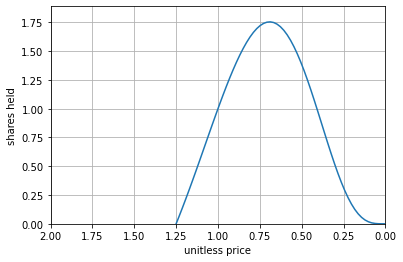

In [219]:
import matplotlib.pyplot as plt; import numpy as np
sp_np = sp.lambdify((q, a, b, r), out.rhs)
_r = 0.25
_b = 1
_a = 0
my_ps = np.linspace(2, 1e-3, num=100)
my_zs = sp_np(my_ps, _a, _b, _r)

plt.plot(my_ps, my_zs)
plt.xlim(2, 0); plt.ylim(0, None); plt.grid()
plt.xlabel("unitless price"); plt.ylabel("shares held")
plt.show()

What do we see here?

Going down in price, we keep buying shares
as our target margin utilization increases, all the way up to a breakdown point.
There, the decrease in our equity drives us toward liquidation, and we are
are forced to start selling to maintain our (still increasing) target usage.
This breakdown point looks to be an important risk/reward decision point for
this kind of strategy. Past the breakdown, the collapse is precipitous.

Going up in price, we gradually sell shares off until we are at all cash.

#### Looking at $r$

We can vary the margin requirement $r$ to see what happens. The transformation
to beta is very straightforward.

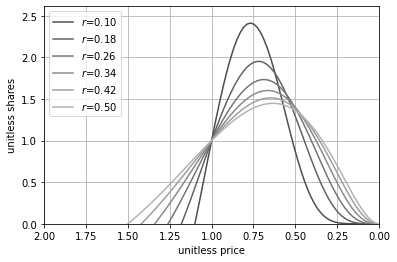

In [220]:
_b = 1; _a = 0
for _r in np.linspace(0.1, 0.5, num=6):
    my_zs = sp_np(my_ps, _a, _b, _r)
    plt.plot(my_ps, my_zs, label=f"$r$={_r:.2f}", color=(_r + .2,) * 3)
plt.xlim(2, 0); plt.ylim(0, None); plt.grid(); plt.legend()
plt.xlabel("unitless price"); plt.ylabel("unitless shares")
plt.show()

We can see that lower margin requirements without changing $a$ or $b$ make the
strategy extreme, with a breakdown drawdown of around 30% for very low
requirements. We see also that with lower requirements we do reach a zero-cash
point.

#### Looking at $b$
Let's pick a realistic $r$ of 0.25. What do we get by varying the drawdown
coefficient $b$?

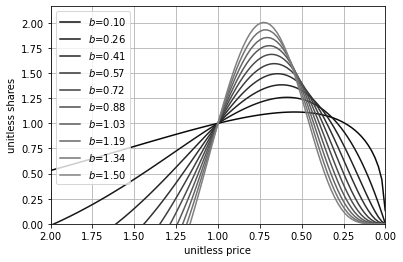

In [221]:
_r = 0.25; _a = 0
for _b in np.linspace(0.1, 1.5, num=10):
    my_ss = sp_np(my_ps, _a, _b, _r)
    plt.plot(my_ps, my_ss, label=f"$b$={_b:.2f}", color=(_b / 3,) * 3)
plt.xlim(2, 0); plt.ylim(0, None); plt.grid(); plt.legend()
plt.xlabel("unitless price"); plt.ylabel("unitless shares")
plt.show()

$b$ has a similar effect to $r$, with a broader range -- very low values
let the strategy become quite conservative, pushing the breakdown cliff
over 50% drawdown. By and large the effect of varying $b$ is the same as $r$.

Going forward, let's pick a reasonably conservative value for $b$ of 0.4.

#### Looking at $a$
Let's look at $a$, keeping $r=0.25$ and fixing $b = 1$. $a$ controls how
much margin we use at the reference price, and can be either negative or
positive. Its valid range is bounded between $-\beta$ and 1.

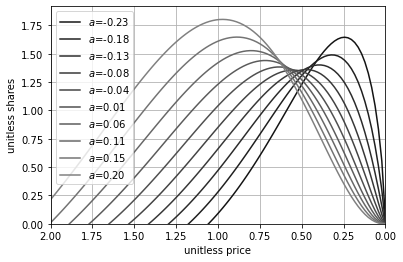

In [222]:
_r = 0.25; _b = 0.4
for _a in np.linspace(-_r/1.1, 0.2, num=10):
    my_ss = sp_np(my_ps, _a, _b, _r)
    plt.plot(my_ps, my_ss, label=f"$a$={_a:.2f}", color=(0.3 + _a,) * 3)
plt.xlim(2, 0); plt.ylim(0, None); plt.grid(); plt.legend()
plt.xlabel("unitless price"); plt.ylabel("unitless shares")
plt.show()

A is unique among the parameters in that it can adjust the number of
shares held at the reference price. We see that positive values of $a$, while
increasing shares held at the reference price actually put the breakdown point
*behind* us, forcing us to sell off as price increases. Negative values
mean we hold cash at the reference price, but will be able to keep buying
as far down as 75% drawdown until we break down.


### Optimizing for our View

Now that we know how this strategy behaves, we should be able to optimize for
$a$ and $b$ given our view of maximum drawdown over some horizon.

We want to solve the following problem:

**Assuming we follow the strategy, given some distribution over drawdowns,
what is the set of $a, b$ with the highest expected shares at the nadir?**

This simple formulation ignores the path of the price, which is irrelevant
for differential trading. We assume our goal is to weather some drawdown and
accumulate the most nadir shares $z_N$. We can optionally add a utility over
shares $u(z_N)$.

#### Formulation

This problem can be stated as follows:

$\arg \max_{a, b} \mathbb E_{q_N \sim p}\left[ u(z(q_N; a, b)) \right ]$


#### Example
We are treating shares as the thing we want in itself -- ownerhip of the means
of production is sweeter than just paper, after all. We'll take $u(z) = z$.
Consistently with this market optimism, we'll model our market movements as a
brownian bridge, which will at some point return to the reference price.

We then want to find the optimal $a, b$ for the nadir distribution induced
by this.

##### A Subtlety
The brownian bridge by definition returns to the reference price,
so if we followed our model perfectly we would simply end with $z(1)$ shares, making
the nadir irrelevant. As mentioned earlier, an actual strategy needs to deviate
from the differential model in some way -- in this case, we will assume that
we "ratchet", trading only down in $q$, doing nothing at any point $T$ where
$q(T) > \min_{t < T} q(t)$. This is safe in that any price "regressions" cannot
liquidate us or otherwise invalidate the model. Following this, we will end up
with $z(\min_t q(t))$ shares at the end.

This is not the only way of doing things -- one might try stopping trading at
the breakdown, in which case the risk of liquidation would need to be modeled, etc.

#### The Expectation

According to https://mat.uab.cat/departament/Publ/prep/p07_17.pdf, the distribution
of the minimum of a Brownian bridge from 1 to 1 is given by:


In [223]:
t0, t1 = sp.symbols('t0 t1')
qm = sp.Symbol('q_m', real=True, positive=True)
q0 = q1 = 1

f_m = 2 / (t1 - t0) * (q0 + q1 - 2 * qm) * sp.exp(
    -(q0 - qm) * (q1 - qm) / (t1 - t0)
)


zqm = zq_expr.subs(q, sp.exp(qm))
zqm

                                     qₘ                 
                                - b⋅ℯ   + b + qₘ⋅(a + b)
                                ────────────────────────
         ⎛      ⎛     qₘ⎞    ⎞             r            
 ⎛ qₘ⎞   ⎝a + b⋅⎝1 - ℯ  ⎠ + r⎠⋅ℯ                        
z⎝ℯ  ⎠ = ───────────────────────────────────────────────
                                r                       

In [224]:
integrand = (f_m * zqm.rhs).simplify()
integrand

                                          2        qₘ                 
                                  (qₘ - 1)    - b⋅ℯ   + b + qₘ⋅(a + b)
                                  ───────── + ────────────────────────
           ⎛      ⎛     qₘ⎞    ⎞   t₀ - t₁               r            
4⋅(qₘ - 1)⋅⎝a + b⋅⎝1 - ℯ  ⎠ + r⎠⋅ℯ                                    
──────────────────────────────────────────────────────────────────────
                             r⋅(t₀ - t₁)                              

In [232]:
simple_integrand = integrand.subs(a, 0).subs(b, 1).subs(r, sp.Rational(1, 4)).subs(t0, 0).subs(t1, 1).simplify()
simple_integrand

                                       2      qₘ    
           ⎛   qₘ    ⎞  4⋅qₘ - (qₘ - 1)  - 4⋅ℯ   + 4
4⋅(qₘ - 1)⋅⎝4⋅ℯ   - 5⎠⋅ℯ                            

In [233]:
sp.integrate(simple_integrand, (qm, 0.1, 1.0)).doit().simplify()

⎛     0.1                                1.0                                0.
⎜      ⌠                                  ⌠                                  ⌠
⎜      ⎮            2      qₘ             ⎮            2      qₘ             ⎮
⎜      ⎮   6⋅qₘ  -qₘ   -4⋅ℯ               ⎮   6⋅qₘ  -qₘ   -4⋅ℯ               ⎮
⎜- 20⋅ ⎮  ℯ    ⋅ℯ    ⋅ℯ       d(qₘ) + 20⋅ ⎮  ℯ    ⋅ℯ    ⋅ℯ       d(qₘ) + 16⋅ ⎮
⎜      ⌡                                  ⌡                                  ⌡
⎝                                                                             

1                                1.0                                0.1       
                                  ⌠                                  ⌠        
            2      qₘ             ⎮            2      qₘ             ⎮        
   7⋅qₘ  -qₘ   -4⋅ℯ               ⎮   7⋅qₘ  -qₘ   -4⋅ℯ               ⎮      6⋅
  ℯ    ⋅ℯ    ⋅ℯ       d(qₘ) - 16⋅ ⎮  ℯ    ⋅ℯ    ⋅ℯ       d(qₘ) + 20⋅ ⎮  qₘ⋅ℯ  
                                  ⌡                